# Homework 2 - Sean Saito

Implementation of SIFT Scale-Space Extrema Extraction.

In [379]:
# Imports
import numpy as np
import scipy as sc
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

# Global variables
im_file = "yale-nus.png"
grey_file = "greyscale.png"

# Greyscale the image
img = Image.open(im_file).convert("L")
img.save(grey_file)

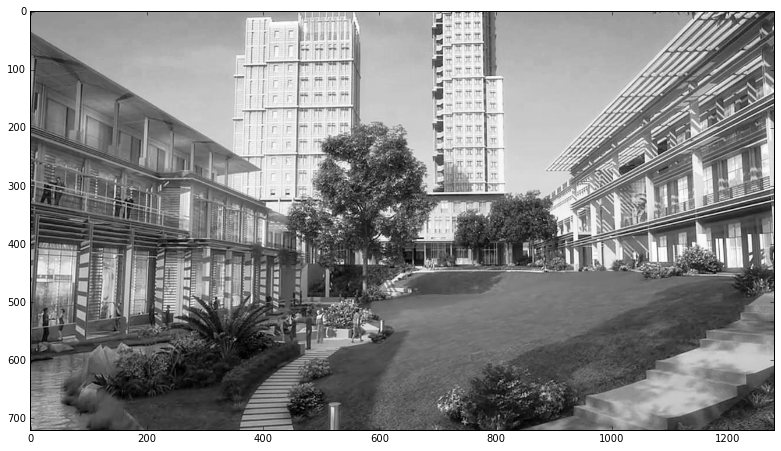

In [358]:
# Now get the image via matplotlib
img = mpimg.imread(grey_file)

# Show original
plt.imshow(img, cmap='Greys_r')

In [359]:
img.shape

(720, 1280)

In [360]:
# Resize the images
level_1 = img
level_2 = scipy.misc.imresize(level_1, 0.8)
level_3 = scipy.misc.imresize(level_2, 0.8)

In [361]:
# Size of the images before convolution
print "Level 1: %s, Level 2: %s, Level 3: %s" % (level_1.shape, level_2.shape, level_3.shape)

Level 1: (720, 1280), Level 2: (576, 1024), Level 3: (460, 819)


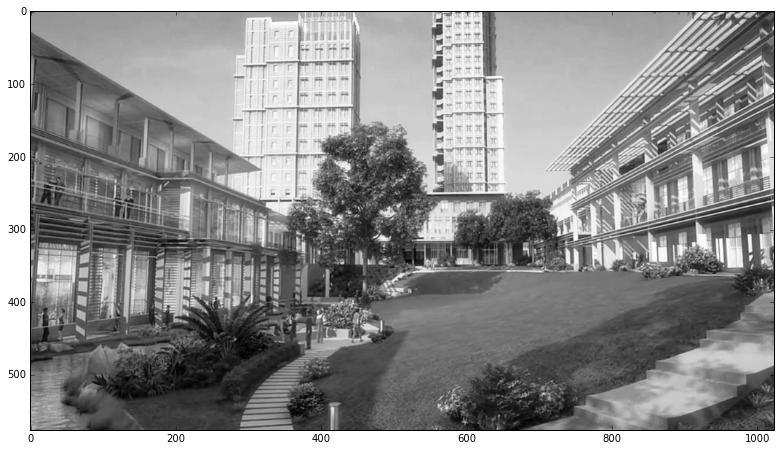

In [362]:
plt.imshow(level_2, cmap='Greys_r')

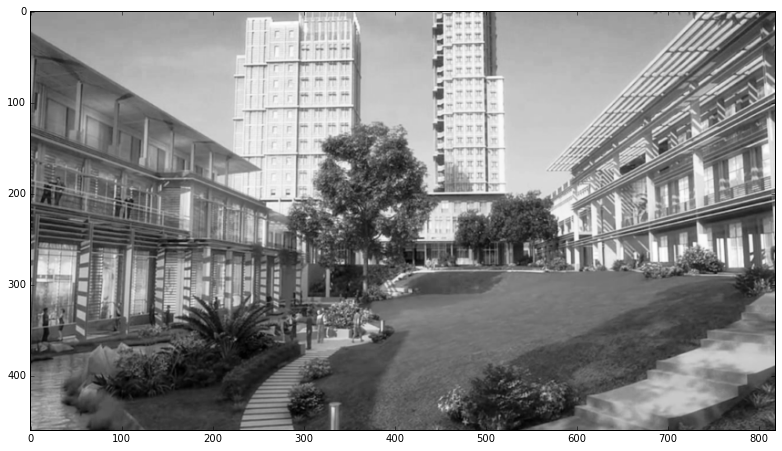

In [363]:
plt.imshow(level_3, cmap="Greys_r")

In [364]:
# Convolution and Gaussian generators

def convolution(X, kernel):
    """
    Apply convolution over an image using a kernel
    
    Args:
        X         : numpy.ndarray
            input image
        kernel    : list
            list of filters. All filters should have the same dimension
    """
    
    shape = X.shape
    kernel_shape = kernel[0].shape
    
    # Number of rows and columns
    target_x = shape[0] - kernel_shape[0] + 1
    target_y = shape[1] - kernel_shape[1] + 1
    
    target = np.zeros((target_x, target_y))
    
    for i in range(target_x):
        for j in range(target_y):
            input_sub = X[i:(i+kernel_shape[0]), j:(j+kernel_shape[1])]
            combined = 0
            for f in kernel:
                interm = np.sum(np.multiply(input_sub, f))
                combined += interm
            target[i, j] = combined
    
    return target

def gaussian(sigma, length=31):
    """
    Generate the gaussian kernel based on sigma.
    Kernel size is lengthxlength
    """
    mask = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            x = abs(i - length/2)
            y = abs(j - length/2)
            e = np.exp((-1) * ((x**2) + (y ** 2)) / (2 * (sigma ** 2)))
            g = e / (2 * np.pi * (sigma ** 2))
            mask[i, j] = g
    return mask

In [365]:
# 5 different Gaussian kernels
gaussians = [[gaussian(i)] for i in [1.0, 2.0, 4.0, 8.0, 16.0]]

# For storing the convolutions
convolve_store = [[] for i in range(3)]

# Convolve
for img, store in zip([level_1, level_2, level_3], convolve_store):
    for kernel in gaussians:
        store.append(convolution(img, kernel))

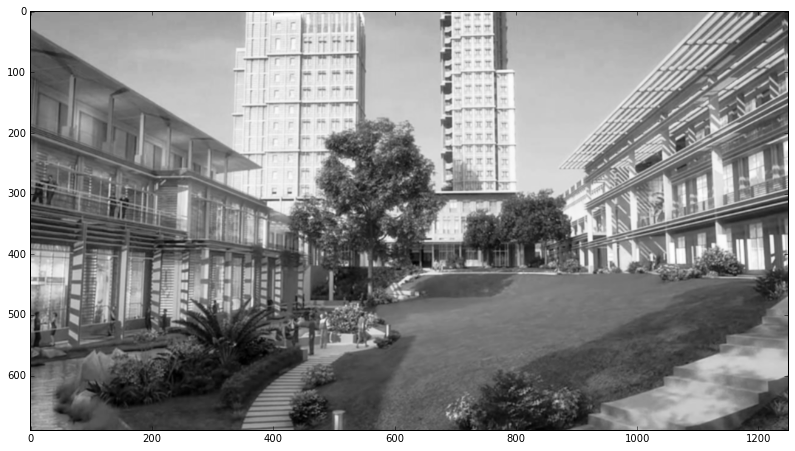

In [366]:
plt.imshow(convolve_store[0][0], cmap="Greys_r")

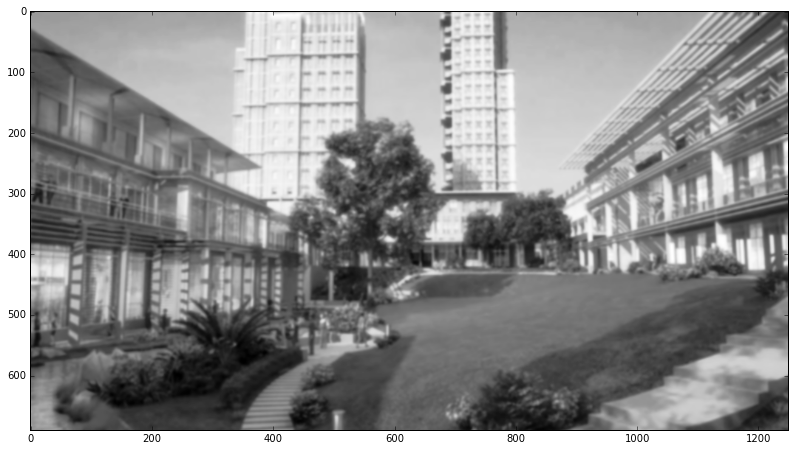

In [367]:
plt.imshow(convolve_store[0][1], cmap="Greys_r")

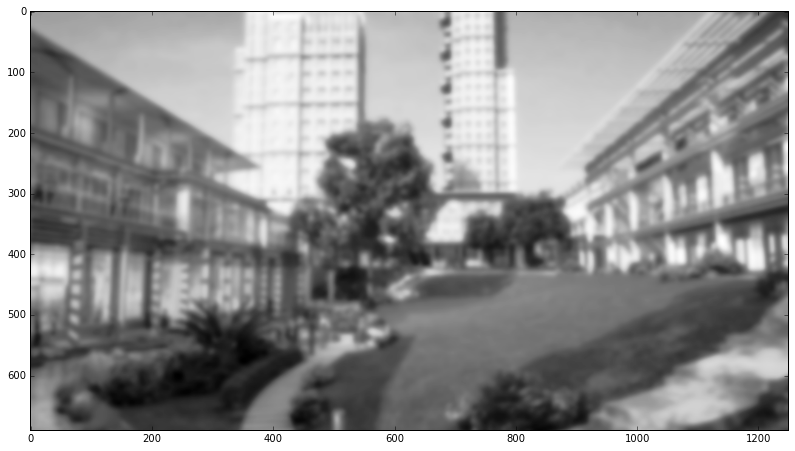

In [368]:
plt.imshow(convolve_store[0][2], cmap="Greys_r")

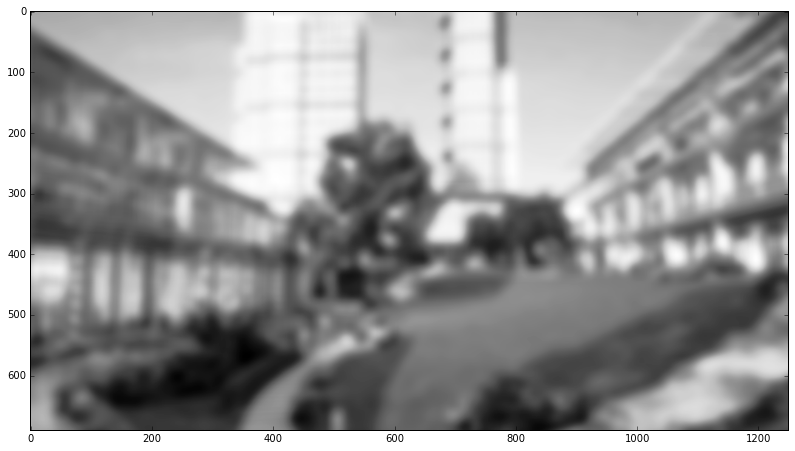

In [369]:
plt.imshow(convolve_store[0][3], cmap="Greys_r")

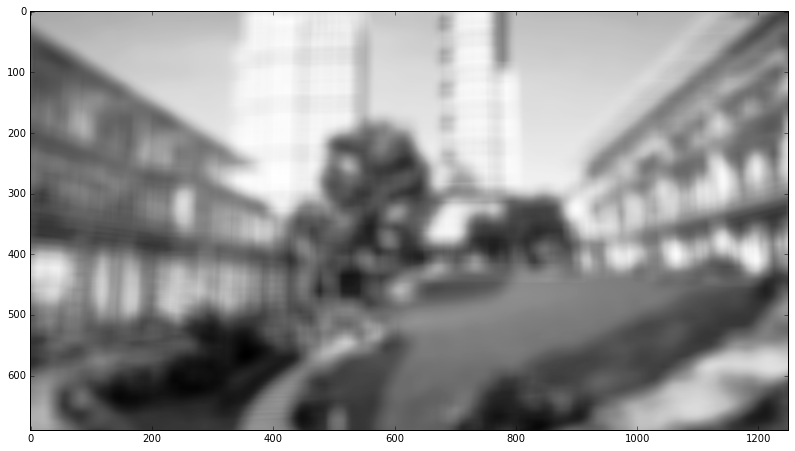

In [370]:
plt.imshow(convolve_store[0][4], cmap="Greys_r")

In [371]:
# Now compute the differences and resize
shapes = [level_1.shape, level_2.shape, level_3.shape]
diffs = [[] for i in range(3)]
for idx, level in enumerate(convolve_store):
    for i in range(len(level)-1):
        img = scipy.misc.imresize(level[i+1]-level[i], shapes[idx])
        diffs[idx].append(img)
        # diffs[idx].append(level[i]-level[i+1])

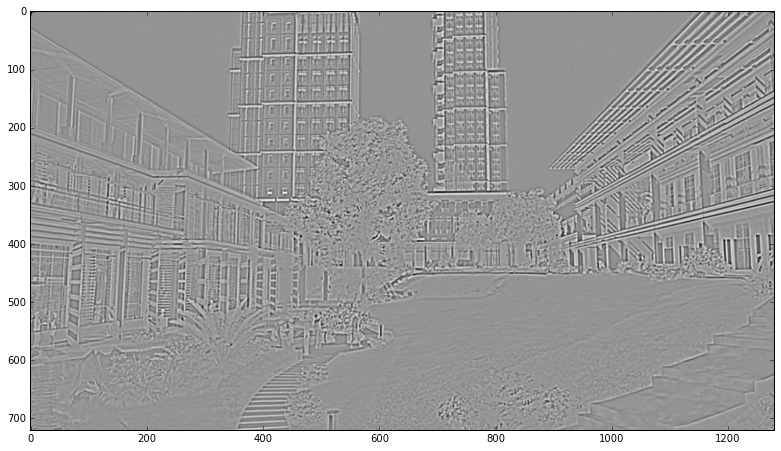

In [372]:
plt.imshow(diffs[0][0], cmap="Greys_r")

In [373]:
# Now extract the key points

def get_neighbors(arr, x, y):
    return [arr[x-1, y], arr[x, y-1], arr[x+1, y], arr[x, y+1], arr[x+1, y+1], arr[x-1, y-1],
           arr[x-1, y+1], arr[x+1, y-1]]

keypoints = [[[], []] for i in range(3)] # First array for x, second array for y points
min_keypoints = [[[], []] for i in range(3)] # For minimum points
for idx, level in enumerate(diffs):
    for i in range(0, len(level)):
        curr_level = level[i]
        for x in range(1, curr_level.shape[0] - 1): # Start from index 1 and end at dim - 1 for simplicity
            for y in range(1, curr_level.shape[1] - 1):
                if i == 0:
                    neighbors = get_neighbors(curr_level, x, y) + get_neighbors(level[i+1], x, y)
                elif i == len(level) - 1:
                    neighbors = get_neighbors(curr_level, x, y) + get_neighbors(level[i-1], x, y)
                else:
                    neighbors = get_neighbors(curr_level, x, y) + get_neighbors(level[i-1], x, y) + get_neighbors(
                                            level[i+1], x, y)
                
                if curr_level[x, y] > max(neighbors): # We have a keypoint
                    keypoints[idx][0].append(x)
                    keypoints[idx][1].append(y)
                if curr_level[x, y] < min(neighbors): # We have a min keypoint
                    min_keypoints[idx][0].append(x)
                    min_keypoints[idx][1].append(y)

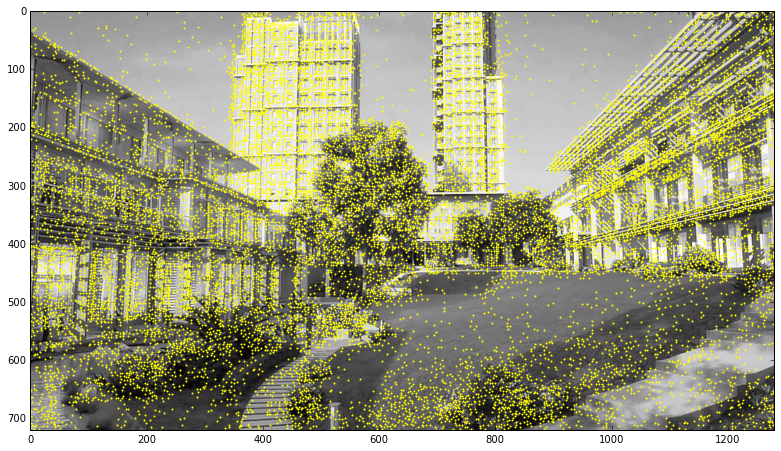

In [375]:
y = keypoints[0][0]
x = keypoints[0][1]
y_min = min_keypoints[0][0]
x_min = min_keypoints[0][1]
plt.scatter(x_min, y_min, zorder=1, s=1.0, color="yellow")
plt.scatter(x,y,zorder=1, s=1.0, color="yellow")
plt.imshow(level_1, zorder=0, extent=[0, level_1.shape[1], level_1.shape[0], 0], cmap="Greys_r")
plt.show()

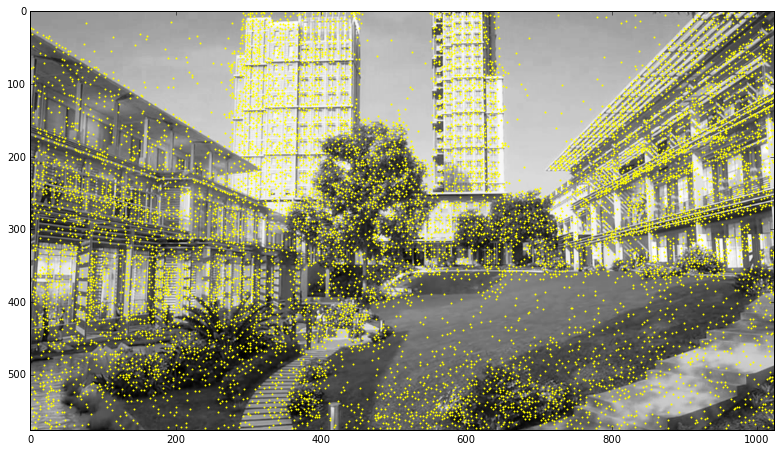

In [377]:
y = keypoints[1][0]
x = keypoints[1][1]
y_min = min_keypoints[1][0]
x_min = min_keypoints[1][1]
plt.scatter(x_min, y_min, zorder=1, s=1.0, color="yellow")
plt.scatter(x,y,zorder=1, s=1.0, color="yellow")
plt.imshow(level_2, zorder=0, extent=[0, level_2.shape[1], level_2.shape[0], 0], cmap="Greys_r")
plt.show()

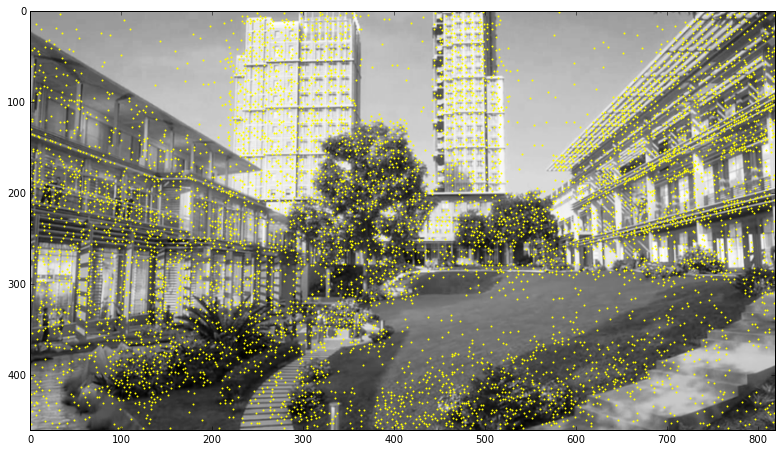

In [378]:
y = keypoints[2][0]
x = keypoints[2][1]
y_min = min_keypoints[2][0]
x_min = min_keypoints[2][1]
plt.scatter(x_min, y_min, zorder=1, s=1.0, color="yellow")
plt.scatter(x,y,zorder=1, s=1.0, color="yellow")
plt.imshow(level_3, zorder=0, extent=[0, level_3.shape[1], level_3.shape[0], 0], cmap="Greys_r")
plt.show()